<a href="https://colab.research.google.com/github/ovieimara/ITNPBD4/blob/master/BD4_Practical_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.api import OLS, add_constant

# Load the dataset
file_path = '/content/PPIACO.csv'
data = pd.read_csv(file_path)

In [15]:
data.head()

,DATE,PPIACO
0,1/1/1913,12.1
1,2/1/1913,12.0
2,3/1/1913,12.0
3,4/1/1913,12.0
4,5/1/1913,11.9


Durbin-Watson statistic: 0.001861255531345427


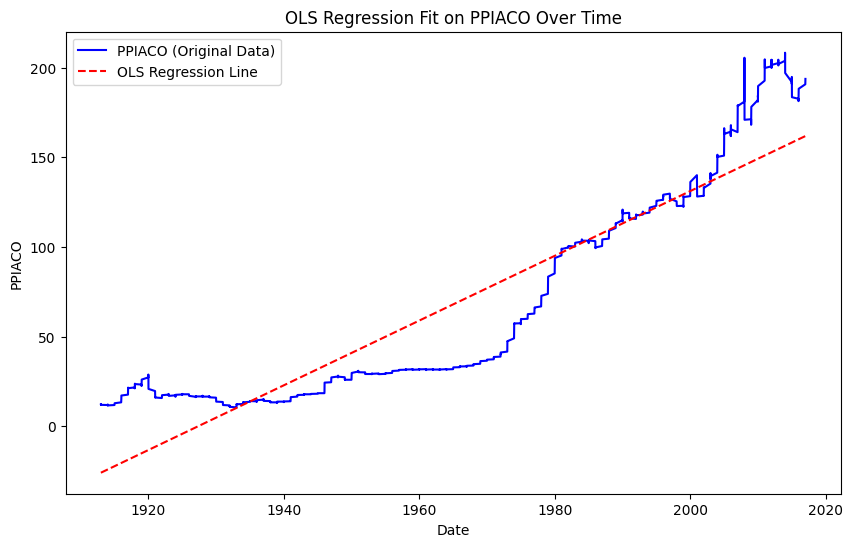

In [16]:
# Step 1: Convert DATE to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')

# Step 2: Prepare data for regression
# Create a time variable as days since the first date for a simple trend model
data['TIME'] = (data['DATE'] - data['DATE'].min()).dt.days  # Days since the first date
X = add_constant(data['TIME'])  # Add a constant to the model
y = data['PPIACO']

# Step 3: Fit a linear regression model
model = OLS(y, X).fit()

# Step 4: Apply the Durbin-Watson test on the residuals
dw_stat = durbin_watson(model.resid)
print("Durbin-Watson statistic:", dw_stat)

# Step 5: Visualize the OLS fit
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['PPIACO'], label='PPIACO (Original Data)', color='blue')
plt.plot(data['DATE'], model.fittedvalues, label='OLS Regression Line', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.title('OLS Regression Fit on PPIACO Over Time')
plt.legend()
plt.show()


ADF Statistic: 1.5664311040370138
p-value: 0.9977532887391664
The time series is likely non-stationary; differencing is needed.


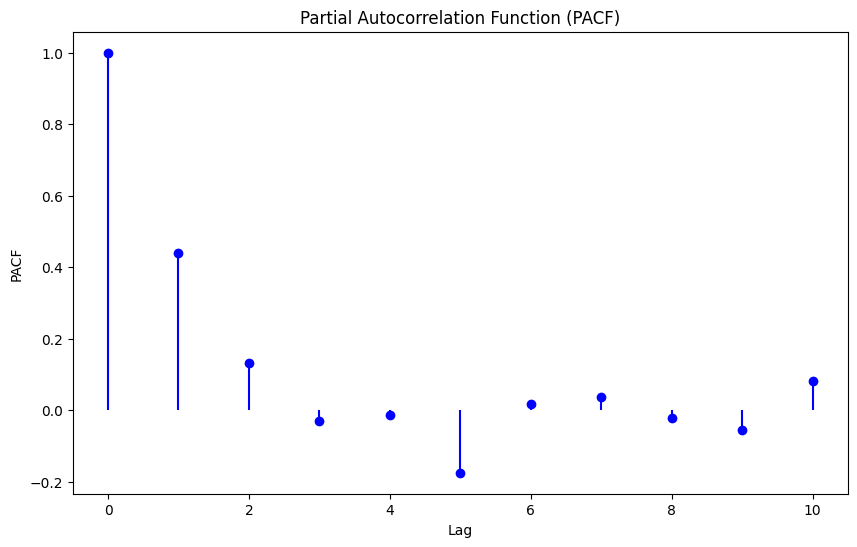

Best AR order (p) by AIC: 3 with AIC: 3193.916648781791
                               SARIMAX Results                                
Dep. Variable:                 PPIACO   No. Observations:                 1256
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1591.958
Date:                Fri, 15 Nov 2024   AIC                           3193.917
Time:                        09:17:27   BIC                           3219.595
Sample:                             0   HQIC                          3203.568
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.0267    287.595      0.237      0.813    -495.649     631.703
ar.L1          1.3888      0.011    127.522      0.000       1.367       1.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf, pacf_ols
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Load data
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data.set_index('DATE', inplace=True)

# Step 1: Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(data['PPIACO'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print("The time series is likely non-stationary; differencing is needed.")
    # Differencing the data to make it stationary
    data['PPIACO_diff'] = data['PPIACO'].diff().dropna()
else:
    print("The time series is stationary; AR model can be directly applied.")
    data['PPIACO_diff'] = data['PPIACO']

# Step 2: Plot PACF to determine the order p
plt.figure(figsize=(10, 6))
pacf_vals = pacf(data['PPIACO_diff'].dropna(), method='ols', nlags=10)
# Remove 'use_line_collection=True' for compatibility with older Matplotlib versions
# and replace with markerline, and markerfacecolor arguments for customization.
plt.stem(range(len(pacf_vals)), pacf_vals, basefmt=" ", markerfmt='bo', linefmt='b-')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

# Step 3: Fit AR model using selected p based on PACF and AIC
# Iterate through possible AR orders and select the best based on AIC
aic_values = []
for p in range(1, 6):  # Test AR models with orders from 1 to 5
    model = ARIMA(data['PPIACO'], order=(p, 0, 0)).fit()  # AR model (no differencing)
    aic_values.append((p, model.aic))

# Select model with minimum AIC
best_order = min(aic_values, key=lambda x: x[1])
print(f"Best AR order (p) by AIC: {best_order[0]} with AIC: {best_order[1]}")

# Step 4: Fit the selected AR model
ar_model = ARIMA(data['PPIACO'], order=(best_order[0], 0, 0)).fit()
print(ar_model.summary())

Explanation

    Stationarity Check: The Augmented Dickey-Fuller test checks if differencing is required. If p-value > 0.05, the series is likely non-stationary, and differencing is needed.
    PACF Plot: A PACF plot helps visualize the lag order where autocorrelations diminish. The number of significant lags (bars crossing the confidence interval) suggests the order pp.
    AIC/BIC Model Selection: A loop through different p values (1 to 5 in this example) fits models and compares AIC scores to select the model with the lowest AIC.

This approach provides a robust way to select the best AR model based on the time series characteristics and fit quality. Let me know if you’d like any additional clarification on model interpretation!

1. Understanding Autoregressive (AR) Models

Autoregressive (AR) models predict future behavior based on past behavior. An AR model of order p, denoted as AR(p), uses the previous p observations to predict the current value.

AR(p) Model Equation:
yt=c+ϕ1yt−1+ϕ2yt−2+⋯+ϕpyt−p+ϵt
yt​=c+ϕ1​yt−1​+ϕ2​yt−2​+⋯+ϕp​yt−p​+ϵt​

    ytyt​: Value at time tt
    cc: Constant term
    ϕ1,ϕ2,…,ϕpϕ1​,ϕ2​,…,ϕp​: Parameters to be estimated
    ϵtϵt​: Error term

2. Selecting the Appropriate AR Model
a. Determining the Order (p) of the AR Model

Selecting the right order p is crucial for capturing the underlying patterns without overfitting. Here are common methods to determine p:

    Partial Autocorrelation Function (PACF):
        PACF Plot: Helps identify the lag after which the partial autocorrelations drop to zero.
        Interpretation: The lag where PACF cuts off (i.e., becomes insignificant) suggests the order p.

    Information Criteria:
        Akaike Information Criterion (AIC): Balances model fit and complexity. Lower AIC indicates a better model.
        Bayesian Information Criterion (BIC): Similar to AIC but imposes a higher penalty for models with more parameters. Lower BIC indicates a better model.
        Hannan-Quinn (HQ): Another criterion less commonly used but can be considered.

    Automated Methods:
        AutoARIMA: Automatically selects the best ARIMA model parameters based on specified criteria like AIC or BIC.

b. Model Selection Process

    Visual Inspection:
        Plot PACF: Identify significant lags.

    Fit Multiple AR Models:
        Fit AR models with different orders p.

    Compare Models Using Information Criteria:
        Select the model with the lowest AIC/BIC.

    Diagnostic Checks:
        Ensure residuals of the selected model show no significant autocorrelation.

3. Implementing AR Model Selection in Python

Below is a comprehensive Python script that guides you through loading your data, visualizing PACF, selecting the appropriate AR model using information criteria, and performing diagnostic checks.
a. Import Necessary Libraries

In [18]:
%%capture
!pip install pmdarima

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


b. Load and Prepare Your Data

In [20]:
# Load the dataset
file_path = '/content/PPIACO.csv'  # Update this path
data = pd.read_csv(file_path)

# Convert 'DATE' to datetime format and set as index
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.sort_values('DATE')  # Ensure data is sorted by date
data.set_index('DATE', inplace=True)

# Display the first few rows to verify
print(data.head())


            PPIACO
DATE              
1913-01-01    12.1
1913-01-02    12.0
1913-01-03    12.0
1913-01-04    12.0
1913-01-05    11.9


c. Visualize Partial Autocorrelation Function (PACF)

<Figure size 1000x600 with 0 Axes>

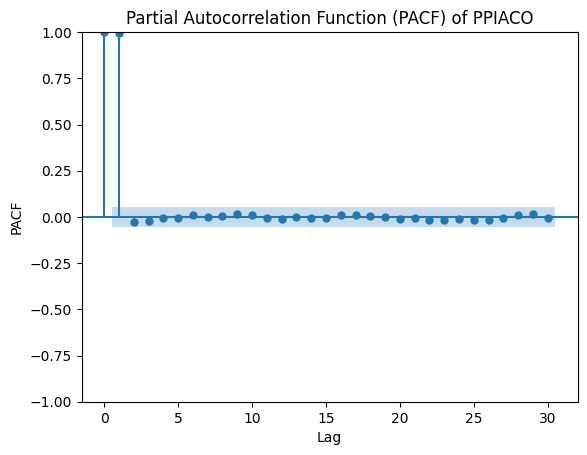

In [21]:
# Plot PACF to identify potential AR orders
plt.figure(figsize=(10,6))
plot_pacf(data['PPIACO'], lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of PPIACO')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

Interpretation:

    Look for the lag after which the PACF values drop below the significance bounds (usually represented by dashed lines).
    The lag at which this drop occurs suggests the potential order p of the AR model.

d. Fit AR(p) Models and Select the Best Order Using AIC

In [22]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# Define the maximum lag to consider
max_lag = 20

# Initialize variables to store the best model information
best_aic = np.inf
best_p = 0
best_model = None

# Iterate over possible p values to find the one with the lowest AIC
for p in range(1, max_lag + 1):
    try:
        model = AutoReg(data['PPIACO'], lags=p, old_names=False).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_p = p
            best_model = model
    except Exception as e:
        print(f"AR({p}) model failed: {e}")

print(f'Best AR order by AIC: p = {best_p} with AIC = {best_aic}')

Best AR order by AIC: p = 20 with AIC = 3075.3051342461686




f. Diagnostic Checks on the Selected Model

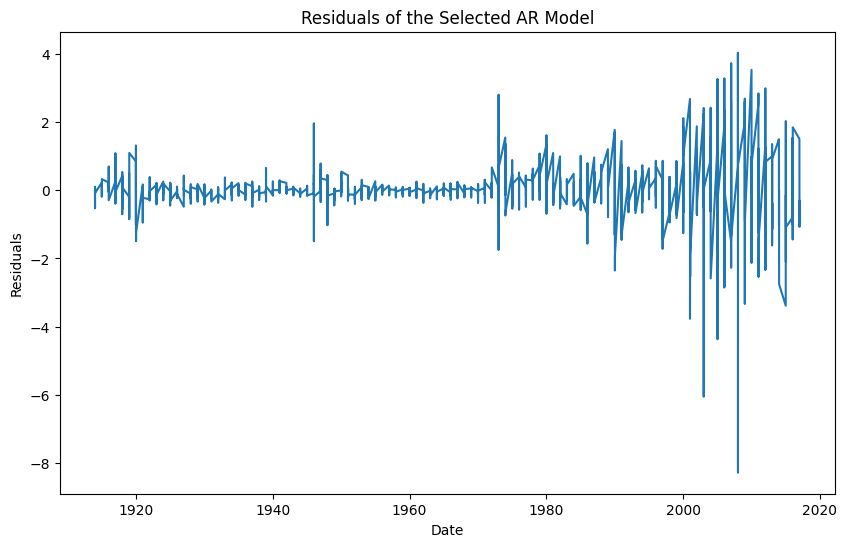

<Figure size 1000x600 with 0 Axes>

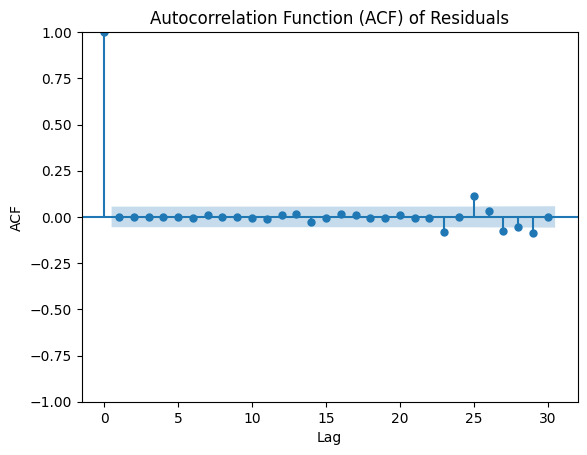

Durbin-Watson statistic of residuals: 1.9999240390586233


In [23]:
# Use the best model found (either from AutoReg or AutoARIMA)
selected_model = best_model  # If using AutoReg
# selected_model = auto_model.arima_res_.fit()  # If using AutoARIMA

# Extract residuals
residuals = selected_model.resid

# Plot residuals to inspect for patterns
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Selected AR Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot ACF of residuals to check for remaining autocorrelation
plt.figure(figsize=(10,6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Perform Durbin-Watson Test on residuals
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic of residuals: {dw_stat}')


Interpretation:

    Residual Plot: Should resemble white noise (no discernible patterns).
    ACF of Residuals: Should show no significant autocorrelations (values within the confidence intervals).
    Durbin-Watson Statistic: Should be close to 2, indicating no autocorrelation in residuals.

If residuals still exhibit autocorrelation, consider increasing the order p or exploring more complex models like ARMA or ARIMA.

4. Example of Model Comparison in Python

Here's how you might evaluate both AR(2) and AR(20) models:

AR(2) AIC: 3190.1804722095053
AR(20) AIC: 3075.3051342461686


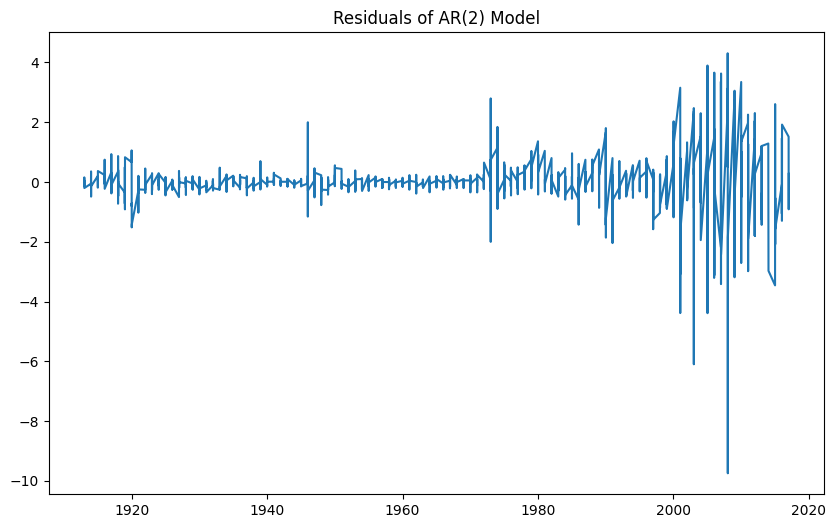

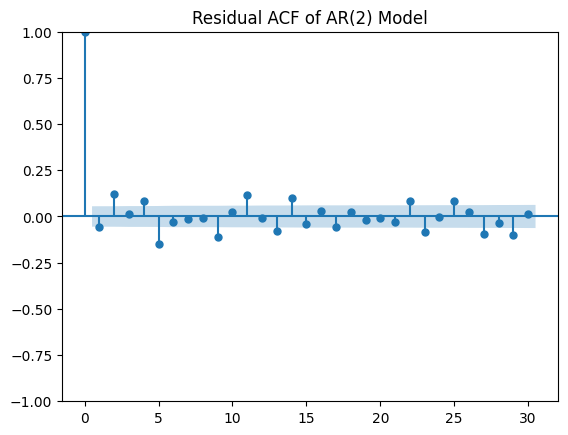

AR(2) Model Durbin-Watson statistic: 2.1137851524247138


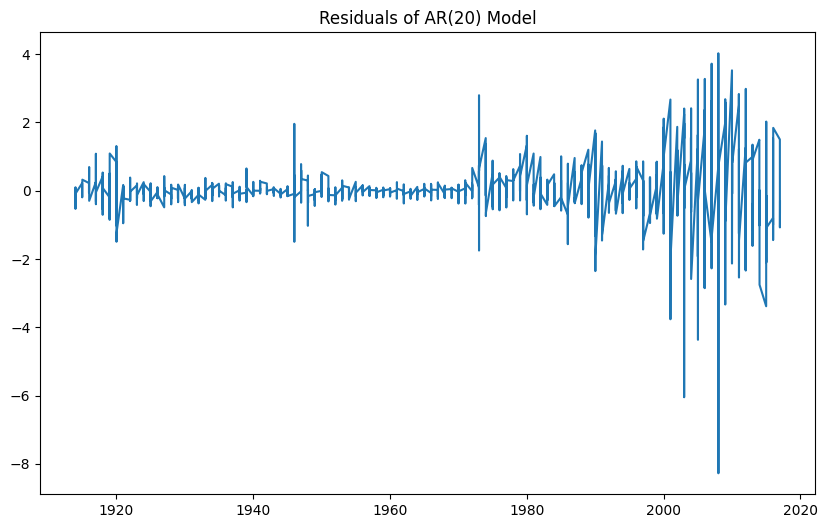

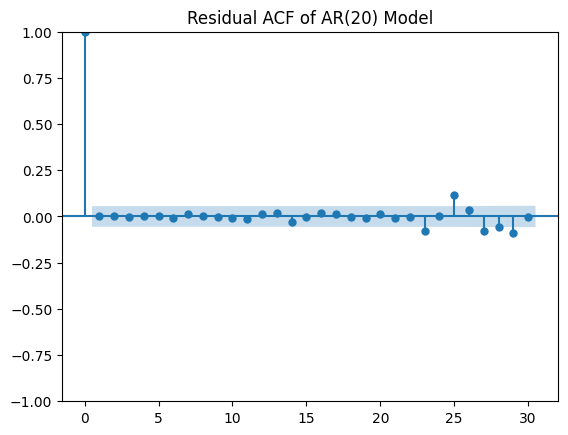

AR(20) Model Durbin-Watson statistic: 1.9999240390586233


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson

# Load your data
data = pd.read_csv("/content/PPIACO.csv")
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.set_index('DATE').sort_index()

# Fit AR(2) and AR(20)
ar2_model = AutoReg(data['PPIACO'], lags=2, old_names=False).fit()
ar20_model = AutoReg(data['PPIACO'], lags=20, old_names=False).fit()

# Print AIC for comparison
print(f"AR(2) AIC: {ar2_model.aic}")
print(f"AR(20) AIC: {ar20_model.aic}")

# Residual diagnostics
for model, name in zip([ar2_model, ar20_model], ["AR(2)", "AR(20)"]):
    residuals = model.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title(f'Residuals of {name} Model')
    plt.show()

    # Plot ACF of residuals
    plot_acf(residuals, lags=30)
    plt.title(f'Residual ACF of {name} Model')
    plt.show()

    # Durbin-Watson statistic
    dw_stat = durbin_watson(residuals)
    print(f'{name} Model Durbin-Watson statistic: {dw_stat}')


Interpretation:

    AIC Comparison: Confirm whether AR(20) has a much lower AIC. If so, it does fit the data better but may still overfit.
    Residual Diagnostics: Choose the model with residuals closest to white noise (both visually and by Durbin-Watson).

Guideline

    If AR(20) provides significantly better residual diagnostics without overfitting, it may be reasonable to use it.
    If AR(2) provides similar diagnostics with less complexity, it could be a more stable choice.

In Python’s statsmodels library, auto_arima() is part of the pmdarima package, which similarly selects ARIMA models based on criteria like AIC and BIC. If auto_arima() returns ARIMA(0,2,1), it means:

    AR(0): No autoregressive terms (lagged observations) were needed.
    I(2): The series required second-order differencing to make it stationary, indicating a significant trend.
    MA(1): One moving average term was selected, meaning a single lagged error term was enough to model the short-term dependencies in the data.

4. Recommendations and Next Steps

    Model Validation:
        After selecting the best AR model, ensure that residuals exhibit no significant autocorrelation and resemble white noise.
        If residuals still show autocorrelation, consider increasing the order p or exploring ARMA/ARIMA models that include moving average components.

    Incorporate Seasonal Components (If Applicable):
        If your data exhibits seasonality, consider SARIMA (Seasonal ARIMA) models to capture seasonal patterns.

    Forecasting:
        Use the selected AR model to forecast future PPIACO values.
        Evaluate forecast accuracy using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), etc.

    Further Model Refinement:
        Explore additional predictors or external variables if available.
        Consider vector autoregression (VAR) if multiple interrelated time series are present.

    Automate Model Selection:
        Utilize automated tools like AutoARIMA for model selection in production environments to streamline the process.

The discrepancy you're observing between an AR(20) model and ARIMA(0,2,1) from auto_arima() likely arises from differences in the criteria each model selection approach emphasizes:

    AIC-Based AR Order Selection (AR(20)):
        When you manually fit AR models of varying orders and use AIC to determine the best order, you might find a high-order AR model like AR(20).
        High AR orders can occur in undifferenced data, especially when there's significant autocorrelation in the series (indicated by slow decay in ACF or PACF plots). The high AR order models long-range dependencies directly rather than differencing.

    auto_arima() Selection (ARIMA(0,2,1)):
        auto_arima() optimizes a model for stationarity and simplicity, potentially applying differencing (I=2 in this case) to make the series stationary before selecting the AR and MA orders.
        With two levels of differencing applied, auto_arima() effectively removes most of the trend and autocorrelation, leading to a more parsimonious model, ARIMA(0,2,1), where fewer terms are needed to capture the remaining short-term structure.

In summary:

    AR(20): This model fits the undifferenced data, capturing long-range dependencies directly with a high AR order.
    ARIMA(0,2,1): This model uses differencing to remove trend and autocorrelation, leaving only a short-term MA component (one lag).

Why auto_arima() Chooses a Simpler Model

The auto_arima() function in Python aims to balance model simplicity with goodness of fit, favoring models with fewer parameters when possible. By applying differencing, it often reduces the required AR order, leading to simpler models like ARIMA(0,2,1) when high levels of autocorrelation are already addressed by differencing.
Which Model Should You Use?

If the series is strongly non-stationary with high autocorrelation, ARIMA(0,2,1) is usually preferable**, as it simplifies the model by first removing non-stationarity through differencing. However, if you’re working with undifferenced data and want to model long-range dependencies directly, the AR(20) model may be informative, though it may risk overfitting with so many parameters.

If the objective is a more interpretable, parsimonious model, stick with auto_arima()’s ARIMA(0,2,1). If capturing all dependencies precisely is crucial, especially in undifferenced data, consider the AR(20) model but be aware of overfitting risks.

#AutoReg version

<Figure size 1000x600 with 0 Axes>

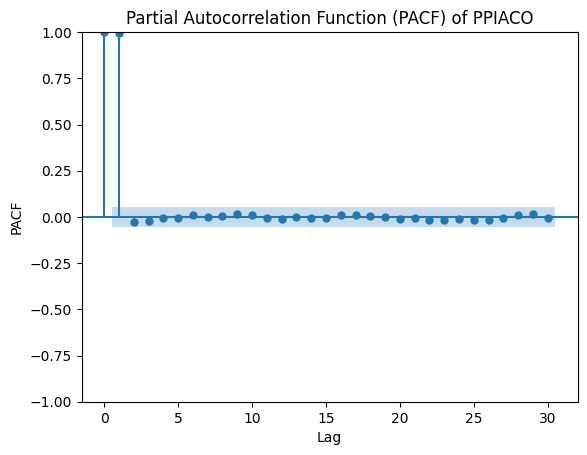

Best AR order by AIC: p = 20 with AIC = 3075.3051342461686


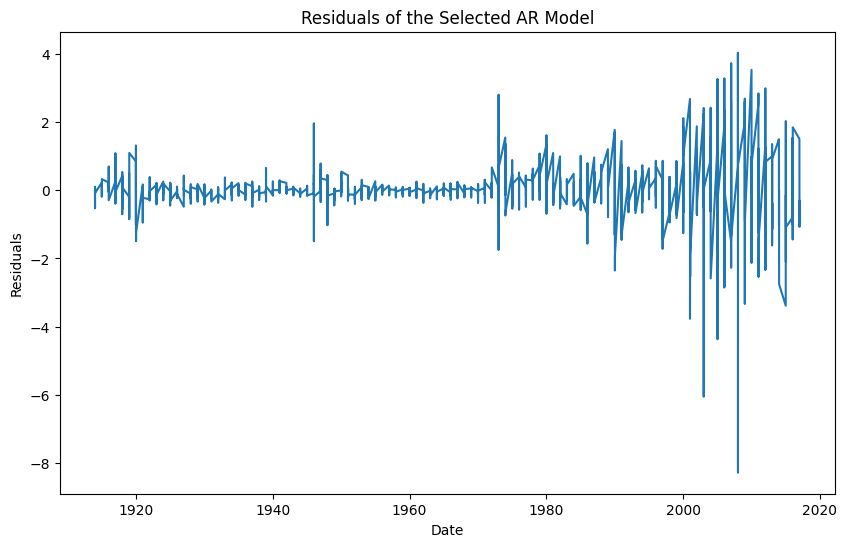

<Figure size 1000x600 with 0 Axes>

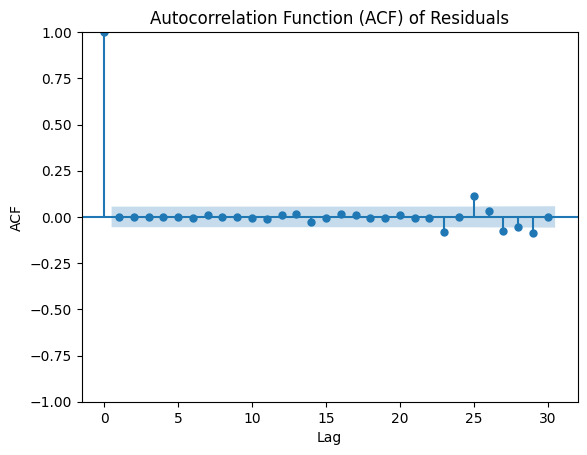

Durbin-Watson statistic of residuals: 1.9999240390586233


In [25]:
# AutoReg Analysis Notebook

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
import warnings
from statsmodels.stats.stattools import durbin_watson

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/PPIACO.csv'  # Update this path
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.sort_values('DATE')
data.set_index('DATE', inplace=True)

# Plot PACF
plt.figure(figsize=(10,6))
plot_pacf(data['PPIACO'], lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of PPIACO')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

# Fit AR(p) models and find the best p using AIC
max_p = 20
best_aic = np.inf
best_p = 0
best_model = None

for p in range(1, max_p + 1):
    try:
        model = AutoReg(data['PPIACO'], lags=p, old_names=False).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_p = p
            best_model = model
    except:
        continue

print(f'Best AR order by AIC: p = {best_p} with AIC = {best_aic}')

# Residual diagnostics for the selected AutoReg model
residuals = best_model.resid

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Selected AR Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10,6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic of residuals: {dw_stat}')


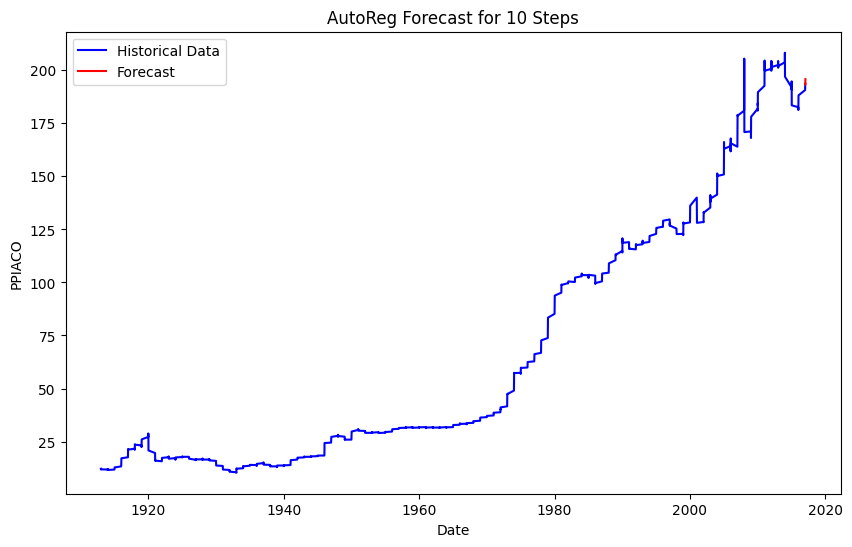

Forecasted values: 1256    193.380446
1257    193.218553
1258    193.485864
1259    193.990666
1260    194.107547
1261    194.364657
1262    194.861308
1263    195.281322
1264    195.555290
1265    195.837667
dtype: float64


In [26]:
# AutoReg Forecasting with Plot

# Define the number of steps you want to forecast
forecast_steps = 10  # Forecast the next 10 steps

# Forecast using the trained AutoReg model
forecast = best_model.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Create a date range for the forecasted values
forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['PPIACO'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title(f'AutoReg Forecast for {forecast_steps} Steps')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')


#ARMA

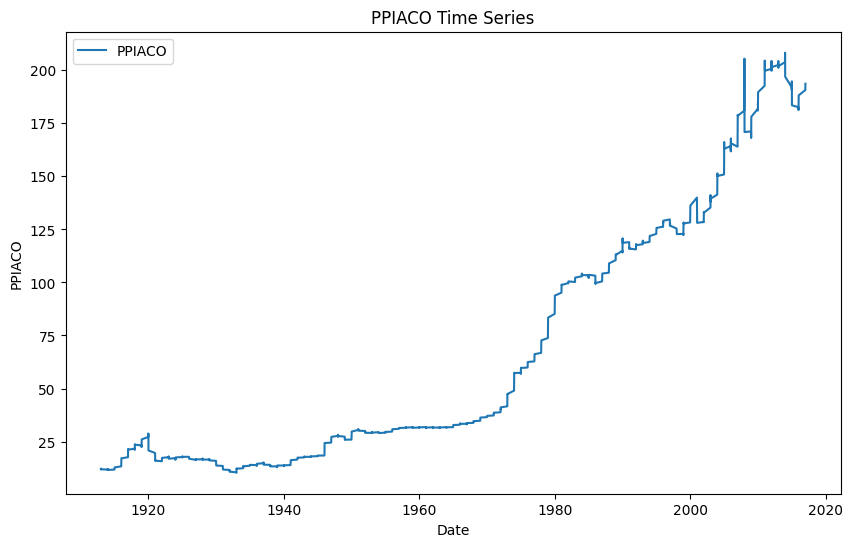

<Figure size 1000x600 with 0 Axes>

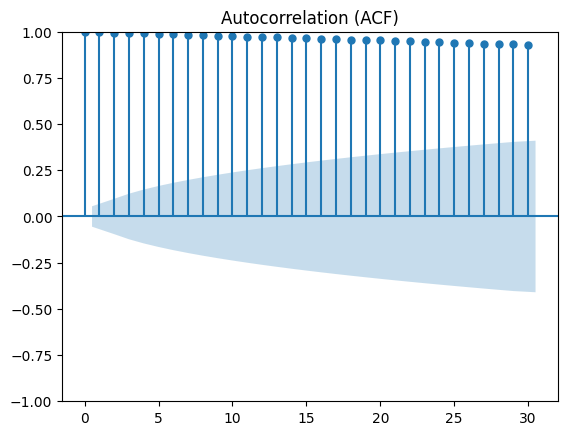

<Figure size 1000x600 with 0 Axes>

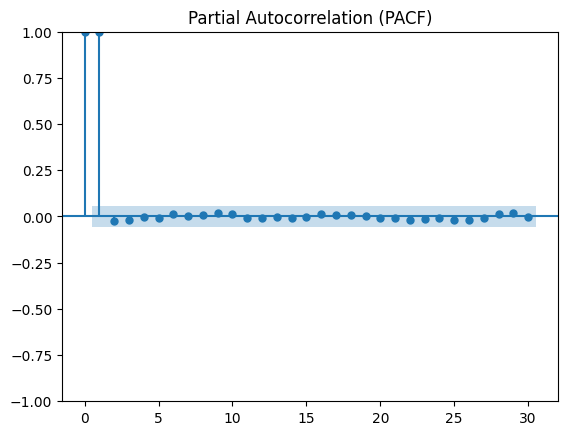

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14875.018, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13167.132, Time=3.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3305.297, Time=1.75 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=4.68 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3225.652, Time=4.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=11545.981, Time=6.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3277.391, Time=7.49 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3211.277, Time=4.71 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=10170.219, Time=2.89 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3214.275, Time=1.42 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=3168.121, Time=1.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=5.81 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=3192.005, Time=1.31 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=31

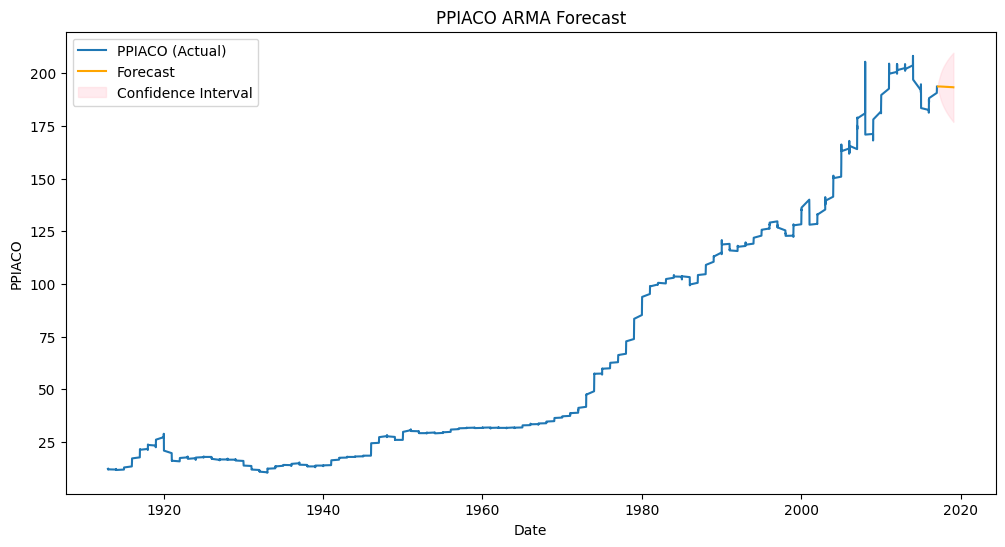

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
file_path = '/content/PPIACO.csv'  # Update this path
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.sort_values('DATE')
data.set_index('DATE', inplace=True)
ppiaco = data['PPIACO']

# Plotting the data to observe the series
plt.figure(figsize=(10, 6))
plt.plot(ppiaco, label='PPIACO')
plt.title('PPIACO Time Series')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.legend()
plt.show()

# Step 1: Plot ACF and PACF to get a sense of possible AR and MA orders
plt.figure(figsize=(10, 6))
plot_acf(ppiaco, lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(ppiaco, lags=30, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.show()

# Step 2: Fit an ARMA model using pmdarima's auto_arima
# Setting d=0 ensures we fit an ARMA model rather than an ARIMA model
auto_arma_model = pm.auto_arima(ppiaco, start_p=0, max_p=5, start_q=0, max_q=5,
                                d=0, seasonal=False, trace=True,
                                information_criterion='aic', suppress_warnings=True)

print(auto_arma_model.summary())

# Step 3: Forecasting using the fitted ARMA model
n_forecast = 24  # Number of periods to forecast
forecast, conf_int = auto_arma_model.predict(n_periods=n_forecast, return_conf_int=True)

# Create a new date range for the forecast
forecast_index = pd.date_range(ppiaco.index[-1], periods=n_forecast + 1, freq='M')[1:]

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(ppiaco, label='PPIACO (Actual)')
plt.plot(forecast_index, forecast, color='orange', label='Forecast')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('PPIACO ARMA Forecast')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.legend()
plt.show()


# AutoARIMA Version

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3600.133, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3411.454, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3347.791, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3598.133, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3345.792, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3409.454, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.86 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 11.672 seconds
                               SARIMAX Results                                
Dep. Variable:                      y 

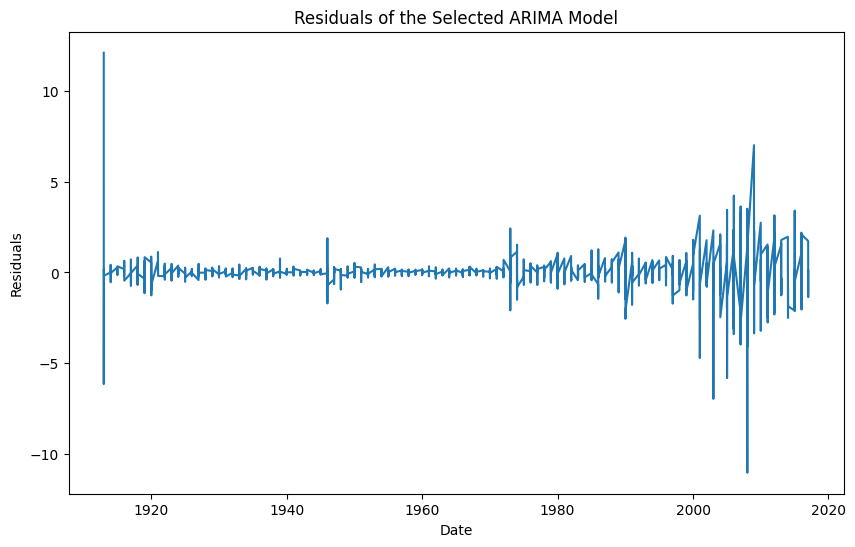

<Figure size 1000x600 with 0 Axes>

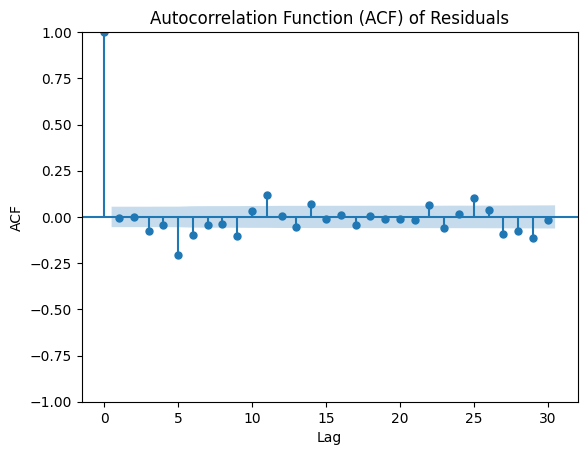

Durbin-Watson statistic of residuals: 1.8988946902835837


In [28]:
# AutoARIMA Analysis Notebook

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
import warnings
from statsmodels.stats.stattools import durbin_watson

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/PPIACO.csv'  # Update this path
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.sort_values('DATE')
data.set_index('DATE', inplace=True)

# AutoARIMA Model Selection
auto_model = pm.auto_arima(
    data['PPIACO'],
    start_p=1, max_p=20,
    seasonal=False,
    stepwise=True,
    trace=True,
    information_criterion='aic',
    suppress_warnings=True
)

print(auto_model.summary())

# Residual diagnostics for the selected AutoARIMA model
residuals = auto_model.arima_res_.resid  # Access the residuals without calling it as a function

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Selected ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10,6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic of residuals: {dw_stat}')


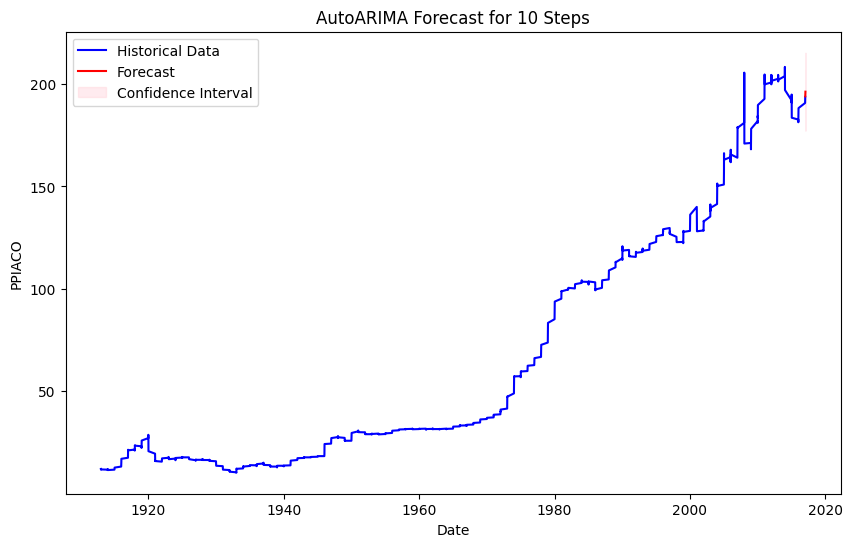

Forecasted values: 1256    193.951129
1257    194.202258
1258    194.453386
1259    194.704515
1260    194.955644
1261    195.206773
1262    195.457902
1263    195.709030
1264    195.960159
1265    196.211288
dtype: float64


In [29]:
# AutoARIMA Forecasting with Plot

# Define the number of steps you want to forecast
forecast_steps = 10  # Forecast the next 10 steps

# Forecast using the trained AutoARIMA model
forecast, conf_int = auto_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a date range for the forecasted values
forecast_dates = pd.date_range(data.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Plot the historical data, forecast, and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['PPIACO'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f'AutoARIMA Forecast for {forecast_steps} Steps')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.legend()
plt.show()

print(f'Forecasted values: {forecast}')


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4016.904, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4262.098, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3675.013, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4033.685, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3444.331, Time=1.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3685.388, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3436.920, Time=1.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3660.251, Time=0.77 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.36 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3438.746, Time=1.84 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

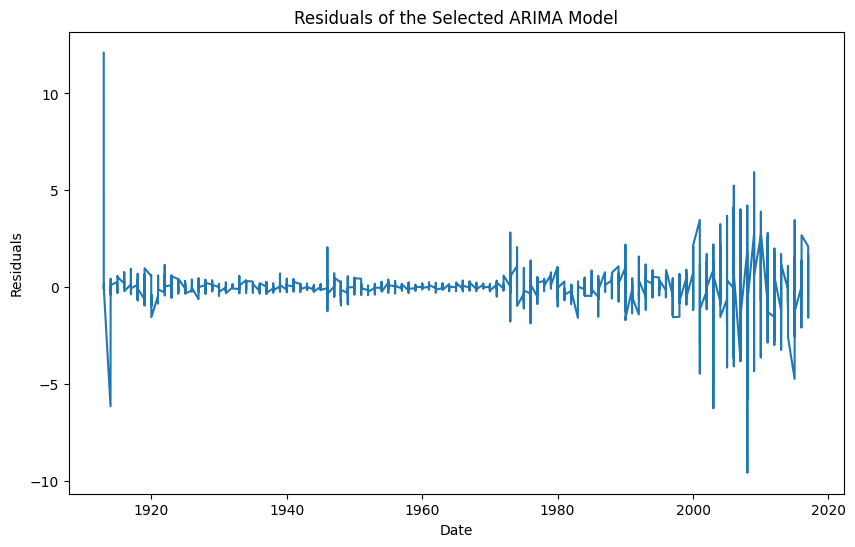

<Figure size 1000x600 with 0 Axes>

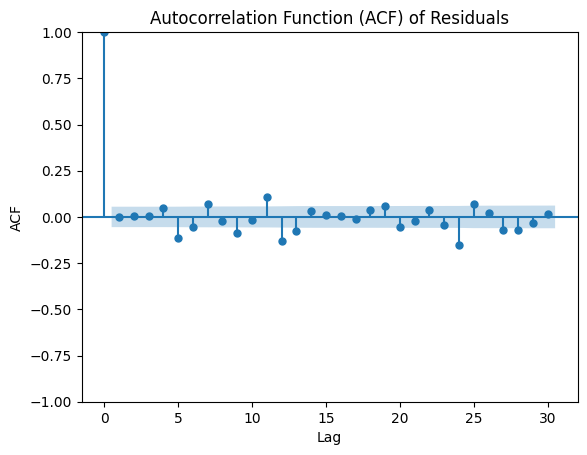

Durbin-Watson statistic of residuals: 1.885926921848334


In [30]:
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import warnings
from statsmodels.stats.stattools import durbin_watson

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/content/PPIACO.csv'  # Update this path
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data = data.sort_values('DATE')
data.set_index('DATE', inplace=True)

# Assume 'data' is a DataFrame with your time series data and an index of datetime format
auto_model = pm.auto_arima(
    data['PPIACO'],            # Target time series
    start_p=1, max_p=3,         # Range for AR order
    start_q=1, max_q=3,         # Range for MA order
    start_P=0, max_P=2,         # Range for seasonal AR order
    start_Q=0, max_Q=2,         # Range for seasonal MA order
    d=1,                        # Differencing order (can be set to None to auto-detect)
    D=1,                        # Seasonal differencing order (can be set to None to auto-detect)
    m=12,                       # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search to reduce computation
    trace=True,                 # Print model details during the search
    information_criterion='aic' # Criterion for model selection
)

print(auto_model.summary())

# Residual diagnostics for the selected AutoARIMA model
residuals = auto_model.arima_res_.resid  # Access the residuals without calling it as a function

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of the Selected ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(10,6))
plot_acf(residuals, lags=30)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic of residuals: {dw_stat}')

#Example of Using auto_arima for SARIMA in Python

Here’s an example of how you would use auto_arima to find the best seasonal model for data with a known seasonal cycle (e.g., monthly data with annual seasonality):
In this example:

    Seasonal Cycle (m): The parameter m is set to 12 to reflect yearly seasonality (12 months per cycle).
    Automatic Search: start_P and max_P set the range for seasonal autoregressive terms, while start_Q and max_Q set the range for seasonal moving average terms. D can be auto-detected based on whether seasonality is observed in the series.

How AutoARIMA Adapts for Seasonal Models (SARIMA)

In a SARIMA model, in addition to the standard ARIMA terms—p (autoregressive), d (differencing), and q (moving average)—we introduce seasonal counterparts:

    P (seasonal autoregressive order),
    D (seasonal differencing order),
    Q (seasonal moving average order),
    m (the length of the seasonal cycle, e.g., 12 for monthly data with yearly seasonality).

#The SARIMA model is represented as SARIMA(p, d, q)(P, D, Q, m).
#Automatic SARIMA Model Selection Process

Using packages like pmdarima in Python (which provides auto_arima), we can automate the search for the best values of both the ARIMA and SARIMA parameters:

    Stepwise Search: The model will test different combinations of p, d, and q along with seasonal P, D, Q, and m values, using stepwise selection to avoid testing all combinations, which speeds up the process.
    Information Criteria: Like with non-seasonal AutoARIMA, the function evaluates each model using criteria like AIC or BIC. The model with the lowest information criterion is selected as the best.
    Seasonal Differencing: auto_arima will assess if seasonal differencing (D) is necessary by checking for seasonality in the data. It will typically test values of D from 0 up to 1 or 2, depending on the detected seasonality.#

In [31]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame containing your time series data
# Fit the SARIMA model with automatic parameter selection
sarima_model = pm.auto_arima(
    data['PPIACO'],
    start_p=1, max_p=3,         # Non-seasonal AR terms
    start_q=1, max_q=3,         # Non-seasonal MA terms
    start_P=0, max_P=2,         # Seasonal AR terms
    start_Q=0, max_Q=2,         # Seasonal MA terms
    d=1,                        # Differencing order
    D=1,                        # Seasonal differencing order
    m=12,                       # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search
    trace=True,                 # Output model selection details
    information_criterion='aic' # Criterion for model selection
)

# Print the summary of the fitted model
print(sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4016.904, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4262.098, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3675.013, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4033.685, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3444.331, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3685.388, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3436.920, Time=1.64 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3660.251, Time=0.76 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3438.746, Time=1.69 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=3

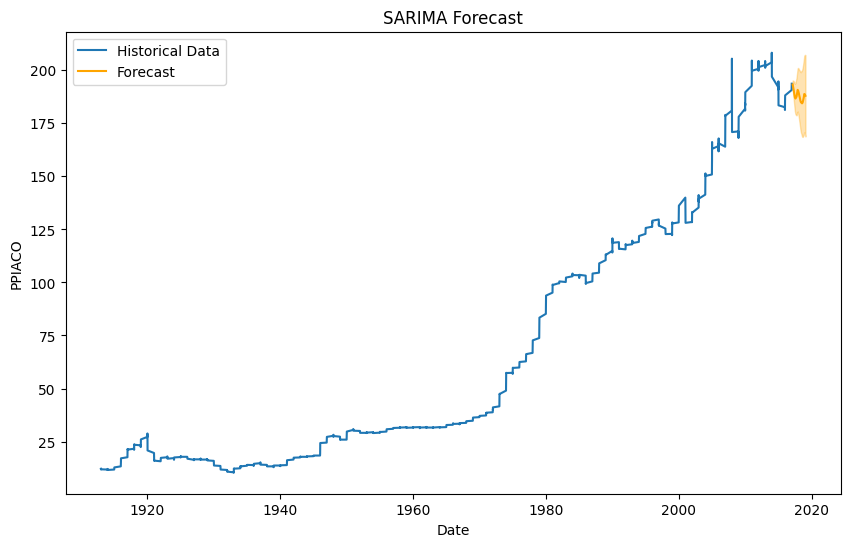

In [32]:
# Define the number of future periods you want to forecast
n_periods = 24  # e.g., forecast 24 months into the future

# Generate the forecast
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a range of dates for the forecasted values
forecast_index = pd.date_range(data.index[-1], periods=n_periods + 1, freq='M')[1:]

# Plot the historical data and the forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(data['PPIACO'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('PPIACO')
plt.legend()
plt.show()

Explanation of the Forecasting Code

    Forecast Generation: The line forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True) generates predictions for the next n_periods time steps and provides confidence intervals.
    Date Range for Forecast: pd.date_range generates a series of dates that start from the last date in the original data and continues for n_periods, matching the forecast horizon.
    Plotting: The plot shows both the historical data and the forecast, with a shaded area representing the confidence intervals, which gives a visual indication of the forecast uncertainty.

# Passengers

In [34]:
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset and set the index to 'Month'
data = pd.read_csv('/content/airline-passengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Passenger Data')
plt.title('Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Fit the SARIMA model with automatic parameter selection
sarima_model = pm.auto_arima(
    data['Passengers'],
    start_p=1, max_p=3,            # Non-seasonal AR terms
    start_q=1, max_q=3,            # Non-seasonal MA terms
    start_P=0, max_P=2,            # Seasonal AR terms
    start_Q=0, max_Q=2,            # Seasonal MA terms
    d=1,                           # Differencing order
    D=1,                           # Seasonal differencing order
    m=12,                          # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,                 # Enable seasonality
    stepwise=True,                 # Enable stepwise search
    trace=True,                    # Output model selection details
    information_criterion='aic'    # Criterion for model selection
)

# Print the summary of the fitted model
print(sarima_model.summary())

# Forecast future values
n_periods = 24  # e.g., forecast for 2 years (24 months)
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a range of dates for the forecasted values
forecast_index = pd.date_range(data.index[-1] + pd.offsets.MonthEnd(1), periods=n_periods, freq='M')

# Plot historical data and the forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(data['Passengers'], label='Historical Data')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3)
plt.title('SARIMA Forecast of Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


KeyError: 'Month'

# When using auto_arima (from pmdarima), it automatically returns a fitted model, and the underlying implementation is often referred to as SARIMAX. Here’s why:

    Underlying SARIMAX Structure: auto_arima uses statsmodels’ SARIMAX for implementation. Even if you are only using seasonal terms without any exogenous variables, the statsmodels SARIMAX class handles all SARIMA functionality under the hood, so it always produces a SARIMAX results object.

    Model Flexibility: SARIMAX is essentially a superset of SARIMA. A SARIMA model is a SARIMAX model without exogenous variables. By leveraging SARIMAX, auto_arima can efficiently handle both SARIMA models (without exogenous terms) and full SARIMAX models (with exogenous terms) within the same function.

    Result Class Consistency: By outputting SARIMAX results, auto_arima keeps a consistent interface regardless of whether you used exogenous terms, seasonal components, or just plain ARIMA terms. This lets users work with both SARIMA and SARIMAX models interchangeably and allows for residual diagnostics and forecasts in a similar way across all models.

So, when using auto_arima without exogenous variables, it functions purely as a SARIMA model. However, the result object remains labeled as a SARIMAX result due to this underlying implementation choice.

#Forecasting with standars SARIMAX model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset and parse dates
data = pd.read_csv('/content/airline-passengers.csv')
data['Month'] = pd.to_datetime(data['Month'])  # Convert Month to datetime
data.set_index('Month', inplace=True)          # Set Month as the index

# Extract Passengers variable from the existing data
passengers = data['Passengers']
# Define date_range based on the index of your data
date_range = data.index  # Use the existing index as date_range

# Generate example fuel price data with some trend and seasonality
np.random.seed(42)
fuel_price = 50 + 2 * np.sin(np.linspace(0, 3 * np.pi, len(date_range))) + np.random.normal(0, 1, len(date_range))

# Create DataFrame
data = pd.DataFrame({'Month': date_range, 'Passengers': passengers, 'Fuel_Price': fuel_price})
data.set_index('Month', inplace=True)

# Plot to visualize
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Passengers')
plt.plot(data['Fuel_Price'], label='Fuel Price', color='orange')
plt.title('Monthly Airline Passengers and Simulated Fuel Price')
plt.xlabel('Date')
plt.legend()
plt.show()

# Fit SARIMAX model with fuel price as an exogenous variable
sarimax_model = SARIMAX(
    data['Passengers'],
    order=(1, 1, 1),               # ARIMA(p, d, q) parameters
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) parameters
    exog=data['Fuel_Price']        # Exogenous variable: Fuel Price
)
sarimax_results = sarimax_model.fit()

# Forecast future values
n_periods = 12  # Forecast for 1 year ahead
future_fuel_price = 50 + 2 * np.sin(np.linspace(3 * np.pi, 4 * np.pi, n_periods)) + np.random.normal(0, 1, n_periods)

# Make predictions
forecast = sarimax_results.get_forecast(steps=n_periods, exog=future_fuel_price.reshape(-1, 1))
forecast_index = pd.date_range(data.index[-1] + pd.offsets.MonthEnd(1), periods=n_periods, freq='M')
forecast_ci = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Historical Passengers')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Passengers', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('SARIMAX Forecast of Monthly Airline Passengers with Fuel Price Exogenous Variable')
plt.xlabel('Date')
plt.legend()
plt.show()
